# Global Imports

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import read_csv
import math, collections
from tensorflow import keras
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, Dropout, MaxPooling2D, MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import io
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.metrics import RootMeanSquaredError
debug = True
useGPU = True

## N-Beats Import
https://github.com/philipperemy/n-beats

Potentially a good one for time series

In [96]:
!pip install nbeats-keras
from nbeats_keras.model import NBeatsNet as NBeatsKeras

# Setup the GPU

In [97]:
# used to load and test for a GPU
if useGPU:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import the Data

In [98]:
data = io.loadmat('data.mat')
data = data["Data"]
labels = np.loadtxt('label.csv', delimiter="\n", dtype=int)

print (data.shape)
print (labels.shape)

(336, 3000)
(336,)


# Fix the data with augmentation

In [99]:
# from here https://tsaug.readthedocs.io/en/stable/

!pip install tsaug
from tsaug import AddNoise, TimeWarp, Crop, Quantize, Drift, Reverse

## Augment the data
with random noise

In [100]:
aug = (
Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
+ Reverse() @ 0.5  # with 50% probability, reverse the sequence
+ AddNoise()
)

print (data.shape)
print (labels.shape)
X_aug = aug.augment(data)
print (X_aug.shape)
data = X_aug

(336, 3000)
(336,)
(336, 3000)


# Fix the unbalanced data with oversampling

In [101]:
random_over_sampler = RandomOverSampler(random_state=1337)
smoteen = SMOTEENN(random_state=1337)
#data, labels = random_over_sampler.fit_resample(data,labels)
data, labels = smoteen.fit_resample(data,labels)
labels = np.array(np.ravel(labels))

# Split the data

In [102]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)
y_train = np.array(y_train)
num_classes = len(np.unique(y_train))

# Reshape the dataset

In [103]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [104]:
print (X_train.shape)
print (X_test.shape)

(58, 1, 3000)
(20, 1, 3000)


# The MLP Model

## Define the base model

In [105]:
mlp_model = Sequential()
mlp_model.add(Dense(600, input_shape=(None,3000),activation='relu'))
mlp_model.add(Dense(500, activation='relu'))
mlp_model.add(Dense(400, activation='relu'))
mlp_model.add(Dense(300, activation='relu'))
mlp_model.add(Dense(200, activation='relu'))
mlp_model.add(Dense(100, activation='relu'))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(25, activation='relu'))
mlp_model.add(Dense(10, activation='relu'))
mlp_model.add(Dense(5, activation='relu'))
mlp_model.add(Dense(1))

## Compile the model

In [106]:
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
mlp_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, None, 600)         1800600   
                                                                 
 dense_67 (Dense)            (None, None, 500)         300500    
                                                                 
 dense_68 (Dense)            (None, None, 400)         200400    
                                                                 
 dense_69 (Dense)            (None, None, 300)         120300    
                                                                 
 dense_70 (Dense)            (None, None, 200)         60200     
                                                                 
 dense_71 (Dense)            (None, None, 100)         20100     
                                                                 
 dense_72 (Dense)            (None, None, 50)         

## The Callback for ealry stopapge

In [107]:
callback_mlp = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=15, verbose=1),
]

## Train the MLP Model

In [108]:
before_mlp = datetime.utcnow()
print ("Start time (UTC): "+str(before_mlp))
with tf.device('/device:GPU:0'):
    # fit the model
  mlp_history = mlp_model.fit(X_train, y_train, epochs=250, 
            verbose=1, 
            workers=8, # multithread
            callbacks=callback_mlp, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_mlp = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_mlp))

# do the math for the time difference
print ("Run time: "+str(after_mlp-before_mlp))

Start time (UTC): 2022-04-15 19:22:16.248630
Epoch 1/250
2/2 [==============================] - 2s 401ms/step - loss: 0.3476 - accuracy: 0.6034 - mean_squared_error: 0.3476 - root_mean_squared_error: 0.5966 - val_loss: 0.2672 - val_accuracy: 0.5300 - val_mean_squared_error: 0.2672 - val_root_mean_squared_error: 0.5169
Epoch 2/250
2/2 [==============================] - 0s 79ms/step - loss: 0.2575 - accuracy: 0.5361 - mean_squared_error: 0.2575 - root_mean_squared_error: 0.5086 - val_loss: 0.2670 - val_accuracy: 0.6000 - val_mean_squared_error: 0.2670 - val_root_mean_squared_error: 0.5167
Epoch 3/250
2/2 [==============================] - 0s 47ms/step - loss: 0.2575 - accuracy: 0.6034 - mean_squared_error: 0.2575 - root_mean_squared_error: 0.5086 - val_loss: 0.2509 - val_accuracy: 0.5700 - val_mean_squared_error: 0.2509 - val_root_mean_squared_error: 0.5009
Epoch 4/250
2/2 [==============================] - 0s 71ms/step - loss: 0.3358 - accuracy: 0.3470 - mean_squared_error: 0.3358 - roo

# The CNN Model

## Define the Model

In [109]:
# to use GPU with tf.device('/device:GPU:0'):
cnn_model = Sequential()
cnn_model.add(Conv1D(256, (1), activation='relu', input_shape=(None, 3000)))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(128, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(64, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(32, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(16, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(8, (1), activation='relu'))
cnn_model.add(Dense(1))

## Compile the Model

In [110]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, None, 256)         768256    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, None, 256)        0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         32896     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, None, 64)          8256      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, None, 64)       

## The Callback for early stoppage

In [111]:
callback_cnn = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the CNN Model

In [112]:
before_cnn = datetime.utcnow()
print ("Start time (UTC): "+str(before_cnn))
with tf.device('/device:GPU:0'):
    # fit the model
  cnn_history = cnn_model.fit(X_train, y_train, epochs=250, 
            verbose=1, 
            workers=8, # multithread
            callbacks=callback_cnn, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_cnn = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_cnn))

# do the math for the time difference
print ("Run time: "+str(after_cnn-before_cnn))

Start time (UTC): 2022-04-15 19:22:23.098546
Epoch 1/250
2/2 [==============================] - 2s 575ms/step - loss: 0.4245 - accuracy: 0.6034 - mean_squared_error: 0.4245 - root_mean_squared_error: 0.6465 - val_loss: 0.4163 - val_accuracy: 0.6000 - val_mean_squared_error: 0.4163 - val_root_mean_squared_error: 0.6452
Epoch 2/250
2/2 [==============================] - 0s 64ms/step - loss: 0.4019 - accuracy: 0.6034 - mean_squared_error: 0.4019 - root_mean_squared_error: 0.6445 - val_loss: 0.3513 - val_accuracy: 0.6000 - val_mean_squared_error: 0.3513 - val_root_mean_squared_error: 0.5927
Epoch 3/250
2/2 [==============================] - 0s 60ms/step - loss: 0.3367 - accuracy: 0.6034 - mean_squared_error: 0.3367 - root_mean_squared_error: 0.5821 - val_loss: 0.3046 - val_accuracy: 0.6000 - val_mean_squared_error: 0.3046 - val_root_mean_squared_error: 0.5519
Epoch 4/250
2/2 [==============================] - 0s 56ms/step - loss: 0.2859 - accuracy: 0.6034 - mean_squared_error: 0.2859 - roo

# The LSTM Model

## Define the model

In [113]:
seq_size=3000
lstm_model=Sequential()
lstm_model.add(LSTM(50,activation='relu', return_sequences=True, input_shape=(None,seq_size)))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(1))

## Compile the model

In [114]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])

## The callback for early stoppage

In [115]:
callback_lstm = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the LSTM Model

In [116]:
# to use GPU with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  before_lstm = datetime.utcnow()
  print ("Start time (UTC): "+str(before_lstm))
  with tf.device('/device:GPU:0'):
      # fit the model
    lstm_history = lstm_model.fit(X_train, y_train, epochs=250, 
              verbose=1, 
              workers=8, # multithread
              callbacks=callback_lstm, 
              validation_data=(X_test,y_test),
              use_multiprocessing=True) # multithread
  # get the stop time
  after_lstm = datetime.utcnow()
  print ("Stop Time (UTC): "+str(after_lstm))

  # do the math for the time difference
  print ("Run time: "+str(after_lstm-before_lstm))

Start time (UTC): 2022-04-15 19:22:35.259083
Epoch 1/250
2/2 [==============================] - 3s 425ms/step - loss: 0.3630 - accuracy: 0.6034 - mean_squared_error: 0.3630 - root_mean_squared_error: 0.6025 - val_loss: 0.3009 - val_accuracy: 0.6000 - val_mean_squared_error: 0.3009 - val_root_mean_squared_error: 0.5486
Epoch 2/250
2/2 [==============================] - 0s 33ms/step - loss: 0.2736 - accuracy: 0.6034 - mean_squared_error: 0.2736 - root_mean_squared_error: 0.5231 - val_loss: 0.2603 - val_accuracy: 0.4500 - val_mean_squared_error: 0.2603 - val_root_mean_squared_error: 0.5102
Epoch 3/250
2/2 [==============================] - 0s 33ms/step - loss: 0.2579 - accuracy: 0.3621 - mean_squared_error: 0.2579 - root_mean_squared_error: 0.5079 - val_loss: 0.2662 - val_accuracy: 0.3500 - val_mean_squared_error: 0.2662 - val_root_mean_squared_error: 0.5159
Epoch 4/250
2/2 [==============================] - 0s 33ms/step - loss: 0.2608 - accuracy: 0.4828 - mean_squared_error: 0.2608 - roo

# The N-BEATS Model
https://github.com/philipperemy/n-beats

## Define the Model

In [117]:
nbeats_model = NBeatsKeras(backcast_length=1)

## Compile the Model

In [118]:
nbeats_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])

## The callback for early stoppage

In [119]:
callback_nbeats = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the N-BEATS Model

In [120]:
# to use GPU with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  before_nbeats = datetime.utcnow()
  print ("Start time (UTC): "+str(before_nbeats))
  with tf.device('/device:GPU:0'):
      # fit the model
    nbeats_history = nbeats_model.fit(X_train, y_train, epochs=250, 
              verbose=1, 
              workers=8, # multithread
              callbacks=callback_nbeats, 
              validation_data=(X_test,y_test),
              use_multiprocessing=True) # multithread
  # get the stop time
  after_nbeats = datetime.utcnow()
  print ("Stop Time (UTC): "+str(after_nbeats))

  # do the math for the time difference
  print ("Run time: "+str(after_nbeats-before_nbeats))

Start time (UTC): 2022-04-15 19:22:40.821870
Epoch 1/250
2/2 [==============================] - 2s 485ms/step - loss: 0.3871 - accuracy: 0.6034 - mean_squared_error: 0.3871 - root_mean_squared_error: 0.6324 - val_loss: 0.3385 - val_accuracy: 0.6000 - val_mean_squared_error: 0.3385 - val_root_mean_squared_error: 0.5818
Epoch 2/250
2/2 [==============================] - 0s 30ms/step - loss: 0.3181 - accuracy: 0.6034 - mean_squared_error: 0.3181 - root_mean_squared_error: 0.5639 - val_loss: 0.2664 - val_accuracy: 0.6000 - val_mean_squared_error: 0.2664 - val_root_mean_squared_error: 0.5161
Epoch 3/250
2/2 [==============================] - 0s 30ms/step - loss: 0.2547 - accuracy: 0.6034 - mean_squared_error: 0.2547 - root_mean_squared_error: 0.5063 - val_loss: 0.2635 - val_accuracy: 0.4000 - val_mean_squared_error: 0.2635 - val_root_mean_squared_error: 0.5133
Epoch 4/250
2/2 [==============================] - 0s 28ms/step - loss: 0.2644 - accuracy: 0.3966 - mean_squared_error: 0.2644 - roo

# Plot the Metrics

## The base plot function

In [121]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot Metrics code from here https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss','mean_squared_error','accuracy','root_mean_squared_error','val_loss','val_accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Training Data')

    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend();

def generate_metrics(history):
  metrics = ['loss','mean_squared_error','accuracy','root_mean_squared_error','val_loss','val_accuracy']
  for n, metric in enumerate(metrics):
    print (metric)
    print ("Min: %.3f"% np.min(history.history[metric]))
    print ("Max: %.3f"% np.max(history.history[metric]))
    print ("Average: %.3f"% np.average(history.history[metric]))
    print ("Mean: %.3f"% np.mean(history.history[metric]))
    print ("\n")

## Metrics for CNN

loss
Min: 0.243
Max: 0.424
Average: 0.255
Mean: 0.255


mean_squared_error
Min: 0.243
Max: 0.424
Average: 0.255
Mean: 0.255


accuracy
Min: 0.517
Max: 0.603
Average: 0.578
Mean: 0.578


root_mean_squared_error
Min: 0.492
Max: 0.647
Average: 0.504
Mean: 0.504


val_loss
Min: 0.244
Max: 0.416
Average: 0.253
Mean: 0.253


val_accuracy
Min: 0.530
Max: 0.600
Average: 0.576
Mean: 0.576




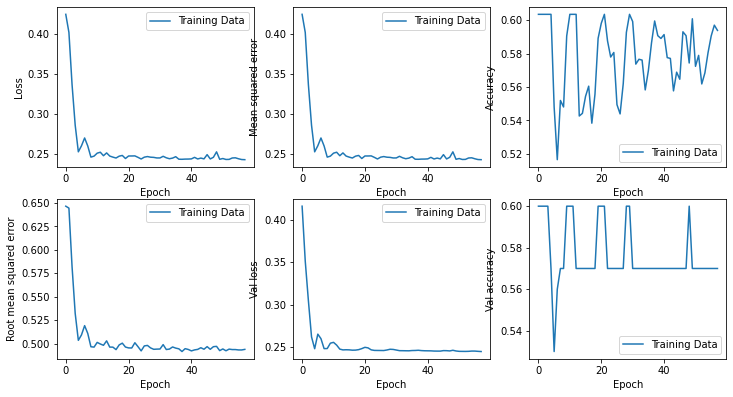

In [122]:
plot_metrics(cnn_history)
generate_metrics(cnn_history)

## Mertric for MLP

loss
Min: 0.243
Max: 0.348
Average: 0.255
Mean: 0.255


mean_squared_error
Min: 0.243
Max: 0.348
Average: 0.255
Mean: 0.255


accuracy
Min: 0.347
Max: 0.603
Average: 0.572
Mean: 0.572


root_mean_squared_error
Min: 0.491
Max: 0.597
Average: 0.504
Mean: 0.504


val_loss
Min: 0.244
Max: 0.278
Average: 0.249
Mean: 0.249


val_accuracy
Min: 0.530
Max: 0.600
Average: 0.581
Mean: 0.581




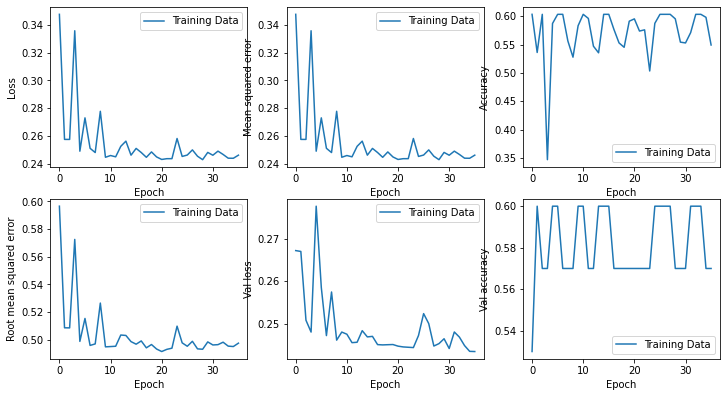

In [123]:
plot_metrics(mlp_history)
generate_metrics(mlp_history)

## Metrics for LSTM

loss
Min: 0.239
Max: 0.363
Average: 0.245
Mean: 0.245


mean_squared_error
Min: 0.239
Max: 0.363
Average: 0.245
Mean: 0.245


accuracy
Min: 0.362
Max: 0.603
Average: 0.594
Mean: 0.594


root_mean_squared_error
Min: 0.489
Max: 0.602
Average: 0.495
Mean: 0.495


val_loss
Min: 0.240
Max: 0.301
Average: 0.243
Mean: 0.243


val_accuracy
Min: 0.350
Max: 0.600
Average: 0.590
Mean: 0.590




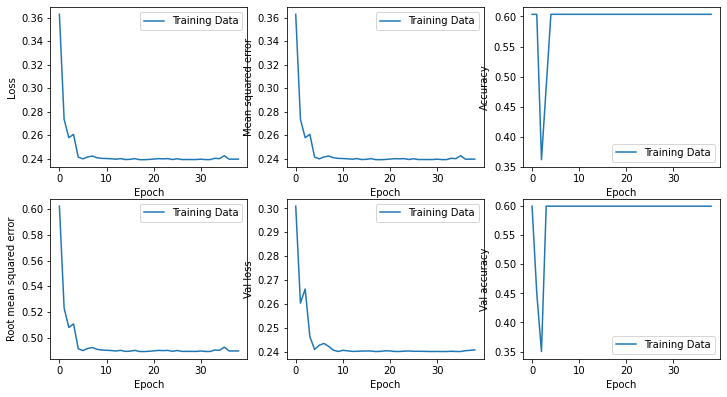

In [124]:
plot_metrics(lstm_history)
generate_metrics(lstm_history)

## Metrics for N-BEATS

loss
Min: 0.239
Max: 0.387
Average: 0.245
Mean: 0.245


mean_squared_error
Min: 0.239
Max: 0.387
Average: 0.245
Mean: 0.245


accuracy
Min: 0.397
Max: 0.603
Average: 0.599
Mean: 0.599


root_mean_squared_error
Min: 0.488
Max: 0.632
Average: 0.495
Mean: 0.495


val_loss
Min: 0.240
Max: 0.339
Average: 0.243
Mean: 0.243


val_accuracy
Min: 0.400
Max: 0.600
Average: 0.596
Mean: 0.596




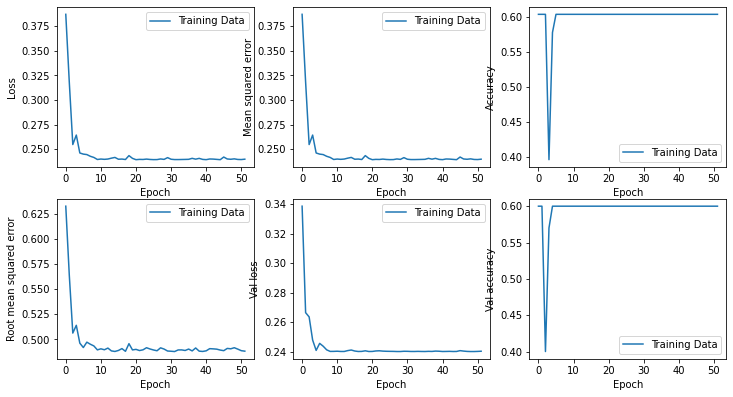

In [125]:
plot_metrics(nbeats_history)
generate_metrics(nbeats_history)